In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

# Halo Shapes

In [44]:
basePath = '/Volumes/G-RAID/simulations/unprocessed/Illustris/Illustris-1'
snapNum = 135
m_dm = 6.3*10**6.0 #dark matter particle mass
little_h = 0.704
Lbox = np.array([75.0]*3)

ptcl_type = {'gas':0,
             'dark-matter':1,
             'tracers':3,
             'stars/wind':4,
             'black holes':5}

## Measure Halo Shapes

In [3]:
from illustris_python.snapshot import loadHalo, snapPath, loadSubhalo
from illustris_python.groupcat import gcPath, loadHalos, loadSubhalos

halo_positions = loadHalos(basePath, snapNum, fields=['GroupPos'])/1000.0

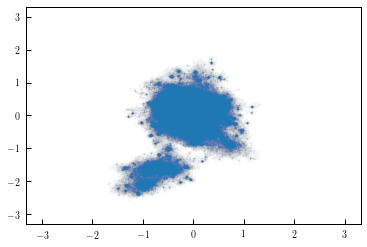

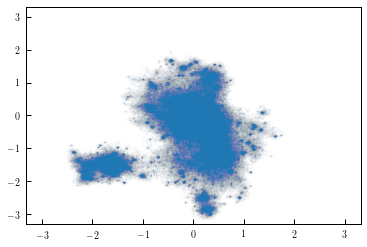

In [13]:
from inertia_tensors import reduced_inertia_tensors

halo_id = 0

# load position
halo_positions = loadHalos(basePath, snapNum, fields=['GroupPos'])/1000.0
halo_position = halo_positions[halo_id]

# load particles
ptcl_coords = loadHalo(basePath, snapNum, halo_id, 1, fields=['Coordinates'])/1000.0

# load halo size
halo_sizes = loadHalos(basePath, snapNum, fields=['Group_R_Mean200'])/1000.0
halo_size = halo_sizes[halo_id]

# account for PBCs
dx = ptcl_coords[:,0] - halo_position[0]
dy = ptcl_coords[:,1] - halo_position[1]
dz = ptcl_coords[:,2] - halo_position[2]

mask = (dx > Lbox[0]/2.0)
dx[mask] = dx[mask] - Lbox[0]
mask = (dx < -Lbox[0]/2.0)
dx[mask] = dx[mask] + Lbox[0]

mask = (dy > Lbox[1]/2.0)
dy[mask] = dy[mask] - Lbox[1]
mask = (dy < -Lbox[1]/2.0)
dy[mask] = dy[mask] + Lbox[1]

mask = (dz > Lbox[2]/2.0)
dz[mask] = dz[mask] - Lbox[2]
mask = (dz < -Lbox[2]/2.0)
dz[mask] = dz[mask] + Lbox[2]

ptcl_coords = np.vstack((dx,dy,dz)).T

I = reduced_inertia_tensors(ptcl_coords)

evals, evecs = np.linalg.eigh(I)
evals = np.sqrt(evals)

Nptcls = len(ptcl_coords)
mask = np.random.random(Nptcls)<0.01

plt.figure()
plt.plot(ptcl_coords[mask,0], ptcl_coords[mask,1], '.', ms=1, alpha=0.01)
plt.xlim([-2*halo_size, 2*halo_size])
plt.ylim([-2*halo_size, 2*halo_size])
plt.show()

plt.figure()
plt.plot(ptcl_coords[mask,1], ptcl_coords[mask,2], '.', ms=1, alpha=0.01)
plt.xlim([-2*halo_size, 2*halo_size])
plt.ylim([-2*halo_size, 2*halo_size])
plt.show()

## measured halo shapes

In [14]:
from astropy.table import Table
t_1 = Table.read('../data/halo_shapes_1.dat', format='ascii')

q = t_1['b']/t_1['a']
s = t_1['c']/t_1['a']

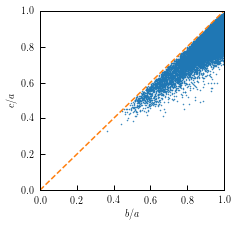

In [15]:
plt.figure(figsize=(3.3,3.3))
plt.plot(q, s, '.', ms=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1], [0,1], '--')
plt.xlabel(r'$b/a$')
plt.ylabel(r'$c/a$')
plt.show()

## galaxy-halo shape correlations

In [70]:
from astropy.table import Table
t_1 = Table.read('../data/galaxy_shapes_1.dat', format='ascii')
t_2 = Table.read('../data/halo_shapes_1.dat', format='ascii')


q_1 = t_1['b']/t_1['a']
s_1 = t_1['c']/t_1['a']

q_2 = t_2['b']/t_2['a']
s_2 = t_2['c']/t_2['a']

In [71]:
# mapping between galaxy id and halo id

gal_ids = t_1['gal_id']

central_ids = loadHalos(basePath, snapNum, fields=['GroupFirstSub'])
centrals = np.in1d(gal_ids, central_ids)

host_ids = loadSubhalos(basePath, snapNum, fields=['SubhaloGrNr'])
host_ids = host_ids[gal_ids]

host_mask = np.in1d(t_2['halo_id'], host_ids)

In [81]:
halo_mask = np.in1d(t_2['halo_id'], host_ids[centrals])
np.all(t_2['halo_id'][halo_mask] == host_ids[centrals])

True

In [123]:
stellar_mass = x['SubhaloMassInRadType'][:,4][gal_ids]*10**10

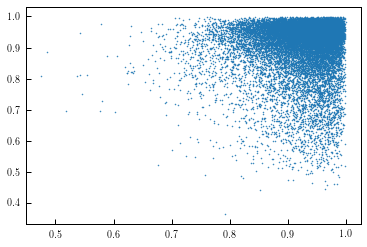

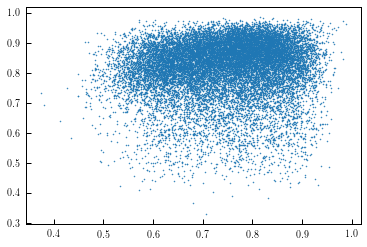

In [85]:
plt.figure()
plt.plot(q_1[centrals], q_2[halo_mask], '.', ms=1)
plt.show()

plt.figure()
plt.plot(s_1[centrals], s_2[halo_mask], '.', ms=1)
plt.show()

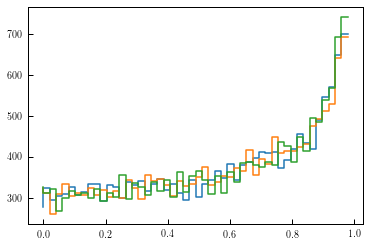

In [101]:
from rotations.vector_utilities import angles_between_list_of_vectors

A_1 = np.vstack((t_1['av_x'], t_1['av_y'], t_1['av_z'])).T
A_2 = np.vstack((t_2['av_x'], t_2['av_y'], t_2['av_z'])).T

theta_ma = angles_between_list_of_vectors(A_1[centrals], A_2[halo_mask])

bins = np.linspace(0,1,50)
counts_1 = np.histogram(np.fabs(np.cos(theta_ma)), bins=bins)[0]

B_1 = np.vstack((t_1['bv_x'], t_1['bv_y'], t_1['bv_z'])).T
B_2 = np.vstack((t_2['bv_x'], t_2['bv_y'], t_2['bv_z'])).T

theta_ma = angles_between_list_of_vectors(B_1[centrals], B_2[halo_mask])

bins = np.linspace(0,1,50)
counts_2 = np.histogram(np.fabs(np.cos(theta_ma)), bins=bins)[0]

C_1 = np.vstack((t_1['cv_x'], t_1['cv_y'], t_1['cv_z'])).T
C_2 = np.vstack((t_2['cv_x'], t_2['cv_y'], t_2['cv_z'])).T

theta_ma = angles_between_list_of_vectors(C_1[centrals], C_2[halo_mask])

bins = np.linspace(0,1,50)
counts_3 = np.histogram(np.fabs(np.cos(theta_ma)), bins=bins)[0]

plt.figure()
plt.step(bins[:-1], counts_1)
plt.step(bins[:-1], counts_2)
plt.step(bins[:-1], counts_3)
plt.show()

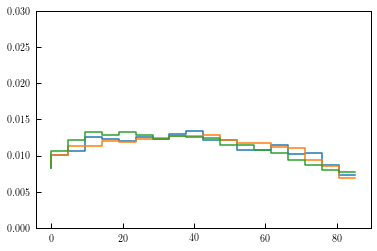

In [121]:
from rotations.vector_utilities import angles_between_list_of_vectors

A_1 = np.vstack((t_1['av_x'], t_1['av_y'], t_1['av_z'])).T
A_2 = np.vstack((t_2['av_x'], t_2['av_y'], t_2['av_z'])).T

theta_ma = np.degrees(angles_between_list_of_vectors(A_1[centrals], A_2[halo_mask]))
mask = theta_ma>90
theta_ma[mask] = np.fabs(theta_ma[mask]-90)

bins = np.linspace(0,90,20)
counts_1 = np.histogram(theta_ma, bins=bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)/np.diff(bins)

B_1 = np.vstack((t_1['bv_x'], t_1['bv_y'], t_1['bv_z'])).T
B_2 = np.vstack((t_2['bv_x'], t_2['bv_y'], t_2['bv_z'])).T

theta_ma = np.degrees(angles_between_list_of_vectors(B_1[centrals], B_2[halo_mask]))
mask = theta_ma>90
theta_ma[mask] = np.fabs(theta_ma[mask]-90)

counts_2 = np.histogram(theta_ma, bins=bins)[0]
counts_2 = 1.0*counts_2/np.sum(counts_2)/np.diff(bins)

C_1 = np.vstack((t_1['cv_x'], t_1['cv_y'], t_1['cv_z'])).T
C_2 = np.vstack((t_2['cv_x'], t_2['cv_y'], t_2['cv_z'])).T

theta_ma = np.degrees(angles_between_list_of_vectors(C_1[centrals], C_2[halo_mask]))
mask = theta_ma>90
theta_ma[mask] = np.fabs(theta_ma[mask]-90)

counts_3 = np.histogram(theta_ma, bins=bins)[0]
counts_3 = 1.0*counts_3/np.sum(counts_3)/np.diff(bins)

plt.figure()
plt.step(bins[:-1], counts_1)
plt.step(bins[:-1], counts_2)
plt.step(bins[:-1], counts_3)
plt.ylim([0,0.03])
plt.show()

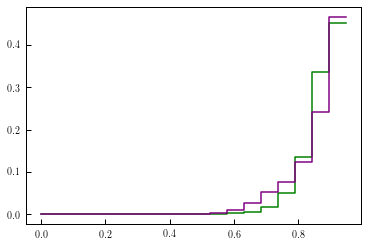

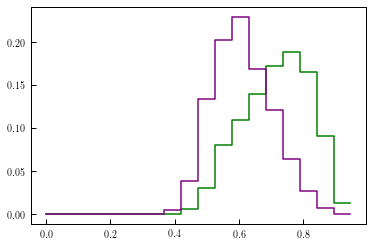

In [130]:
mask_1 = (stellar_mass>10**9) & (stellar_mass<10**10.5)
mask_2 = (stellar_mass>10**10.5) & (stellar_mass<10**12)

bins = np.linspace(0,1,20)

counts_1 = np.histogram(q_1[mask_1], bins=bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)
counts_2 = np.histogram(q_1[mask_2], bins=bins)[0]
counts_2 = 1.0*counts_2/np.sum(counts_2)

plt.figure()
plt.step(bins[:-1], counts_1, color='green')
plt.step(bins[:-1], counts_2, color='purple')
plt.show()

counts_1 = np.histogram(s_1[mask_1], bins=bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)
counts_2 = np.histogram(s_1[mask_2], bins=bins)[0]
counts_2 = 1.0*counts_2/np.sum(counts_2)

plt.figure()
plt.step(bins[:-1], counts_1, color='green')
plt.step(bins[:-1], counts_2, color='purple')
plt.show()